## Transverse field Ising model to demo primitives

OBJECTIVE: Trying to see how much noise in gates affects values. 
    (Applying gate then inverse gate should *ideally* result in the same value, but noise can prevent that.)


See paper that we're implementing: https://www.nature.com/articles/s41586-023-06096-3

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np
# Define SYdgGate because it's not defined within qiskit.circuit.library
SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}^\dag$")
## trotter_barriers and layer_barriers are optional parameters to help with visualization
def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits = 0, trotter_barriers = False, layer_barriers = False):
    ## Ensure that there are classical bits if provided
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    for trotter_step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        ## To help with visualization
        if trotter_barriers:
            qc.barrier()
    return qc

# Compress R-gates to reduce noise and delay, such as layering them.

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers):
    # Adding Rzz in the even layers
    for i in range(0, qc.num_qubits-1, 2):
        ## Rzz can be broken into composite gates
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        ## CNot between all pairs
        qc.cx(i, i+1)
        ## sqrt of y inverse 
        qc.append(SYdgGate, [i + 1])
    if layer_barriers:
        qc.barrier()
    ## Applying Rzz in the even layers    
    for i in range(1, qc.num_qubits-1, 2):
        ## Rzz can be broken into composite gates
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i + 1])
    if layer_barriers:
        qc.barrier()
    ## Paper says to apply Rx gate to all qubits
    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
        
        

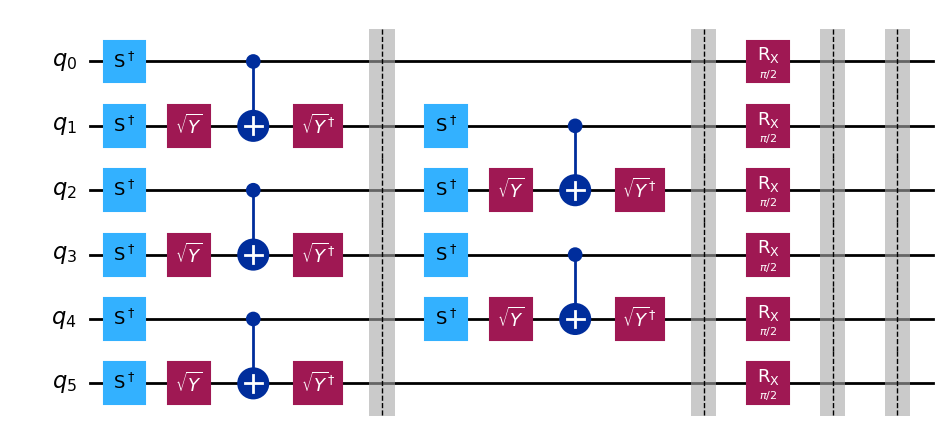

In [2]:
## Test functions defined above
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5 * np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)

## Draws quantum circuit!
## Barriers divide Rzz applied on even layers | Rzz gate applied on odd layers | Rx gate
qc.draw(output = 'mpl', fold = -1)

# Demo: Sampler

In [5]:
# Code the circuit going backwards

## Adds gate to circuit rather than returning an enitrely new circuit
def append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):
    for trotter_step in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        ## To help with visualization
        if trotter_barriers:
            qc.barrier()
    return qc

# Compress R-gates to reduce noise and delay, such as layering them.
## MIRRORED OF ORIGINAL 1d_tfim_trotter_layer -> REVERSED ORDER!!
def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers):
    ## Paper says to apply Rx gate to all qubits
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
    ## Applying Rzz in the odd layers
    ## INVERT ALL GATES  
    for i in range(1, qc.num_qubits-1, 2):
        ## Inverse of SYdgGate is SYGate
        qc.append(SYGate, [i + 1])
        # (Cnot gate is its own inverse)
        qc.cx(i, i+1)
        ## Inverse of SYGate is SydgGate
        qc.append(SYdgGate, [i+1])
        ## Inverse of s-dagger gate is s gate
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier()
    # Adding Rzz inverse in the even layers
    for i in range(0, qc.num_qubits-1, 2):
        ## Inverse of SYdgGate is SYGate
        qc.append(SYGate, [i + 1])
        # (Cnot gate is its own inverse)
        qc.cx(i, i+1)
        ## Inverse of SYGate is SydgGate
        qc.append(SYdgGate, [i+1])
        ## Inverse of s-dagger gate is s gate
        qc.s([i, i+1])
    if layer_barriers:
        qc.barrier()
  
    
        

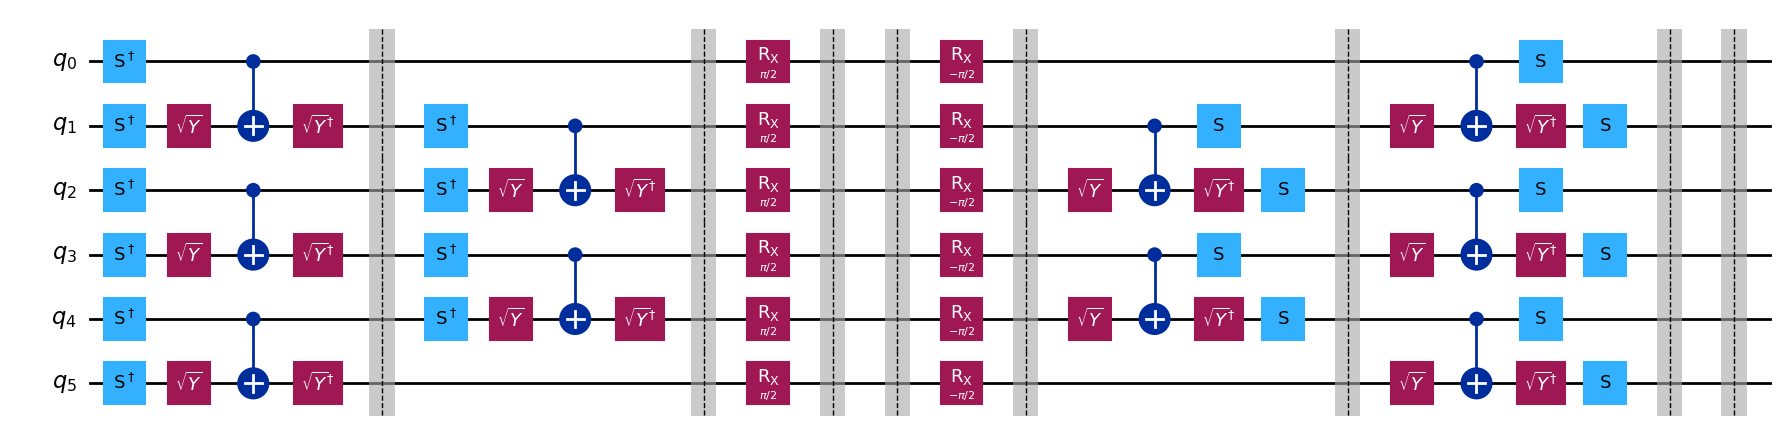

In [10]:
## Testing appending inverse gate to generate a GENERIC UNITY GATE

qc_mirrored = append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
## Shows initial forward direction then inverse direction
qc.draw(output='mpl', fold = -1)

## Step 1: Map the problem to circuits and observables 

In [11]:
## Increase # of trotter steps and invert it at each step to see the survival probability of an all zero string
max_trotter_steps = 10
num_qubits = 100
measured_qubits = [49, 50]

qc_list = []
for trotter_step in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, len(measured_qubits), trotter_barriers=True, layer_barriers=True)
     ## mirror the circuit
    append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
    ## Measure on just two qubits and assign on classical registers
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc)
    
   

In [7]:
## Visualize for first trotter step (measures are appended to the 49th and 50th qubits)
## qc_list[1].draw(output='mpl') 

## Step 2: Optimize

In [18]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)

qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level = 1)

## Step 3: Execute on hardware

In [9]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run(qc_transpiled_list)
job_id = job.job_id()
print(job_id)



cs78dd5kfpw00080ya0g


## Step 4: Post-processing and plotting

In [10]:
job_id = "cs75d0myhpyg008b23kg"
job = service.job(job_id)

survival_probability_list = []
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0' * len(measured_qubits)] / data.c.num_shots)
    except:
        survival_probability_list.append(0)

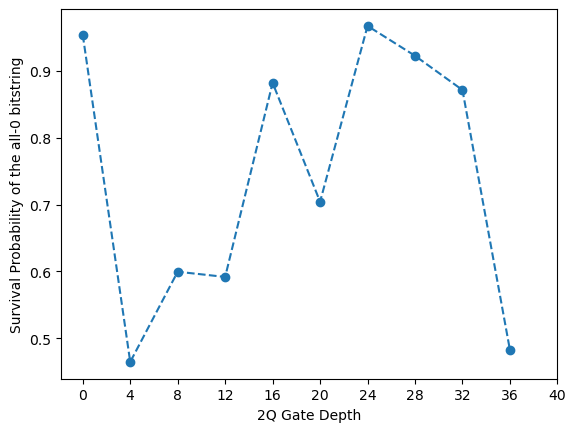

In [11]:
import matplotlib.pyplot as plt

plt.plot(list(range(0, 4 * max_trotter_steps, 4)), survival_probability_list, '--o')
plt.xlabel('2Q Gate Depth')
plt.ylabel('Survival Probability of the all-0 bitstring')
plt.xticks(np.arange(0, 44, 4))
## Downward trend in survivability as 2Q Gate Depth increases
plt.show()

## Estimator

Premise: As the Rx angle goes from 0 to pi/2, the magneziation drops

## Step 1 Mapping the problem

In [12]:
from qiskit.circuit import Parameter

rx_angle = Parameter("rx_angle")
trotter_steps = 2
## See what happens to expectation value after 2 trotter steps
qc = generate_1d_tfim_circuit(num_qubits, trotter_steps, rx_angle)

## Sweep over Rx angle and measure magnization 

## dialing in on magnization of middle qubit
from qiskit.quantum_info import SparsePauliOp
middle_index = num_qubits // 2
## Sparse representation of an operator, used for performing arithmetic for hundred of qubits
observable = SparsePauliOp("I" * middle_index + "Z" + "I" * (middle_index - 1))

## Step 2: Optimize the circuit

In [13]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService
backend_name = 'ibm_brisbane'
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)

qc_transpiled = transpile(qc, backend=backend, optimization_level = 1)
observable = observable.apply_layout(qc_transpiled.layout)

## Step 3: Execute on Quantum Hardware

In [14]:
## Need to define the range that the parameter will have
from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

min_rx_angle = 0
max_rx_angle = np.pi/2
num_rx_angle = 12
rx_angle_list = np.linspace(min_rx_angle, max_rx_angle, num_rx_angle)
## Defining options
options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = EstimatorV2(backend=backend, options=options)

## Do the run: pass in single circuit, observables, rx_angle_list as a single tuple
job = estimator.run([(qc_transpiled, observable, rx_angle_list)])
print(job.job_id())

cs78dhpyhpyg008b2dg0


## Step 4: Post-processing and plotting

(-0.1, 1.1)

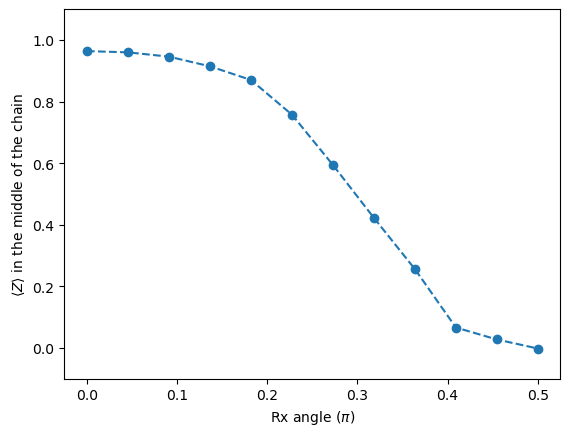

In [19]:
job_id = "cs7887r75q40008v5ttg"
exp_val_list = job.result()[0].data.evs
plt.plot(rx_angle_list / np.pi, exp_val_list, '--o')
plt.xlabel(r'Rx angle ($\pi$)')
plt.ylabel(r'$\langle Z \rangle$ in the middle of the chain')
plt.ylim(-0.1, 1.1)